In [1]:
import gmsh
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm, patches, collections

In [2]:
experiment='run_330d_iabp'

In [3]:
mesh_file='/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/par32small_arctic_10km.msh'

In [4]:
gmsh.initialize()
file = gmsh.open(mesh_file)

In [10]:
file

In [5]:
# Number of partitions (i.e. as many partitions as processors on which the simulation has run)
NP =  gmsh.model.getNumberOfPartitions()
print(NP)

# Get all Entities from gmsh file
entities = gmsh.model.getEntities()

0


In [6]:
def GetPartitionsFromEntities(entities,NP):
    """ Gets mesh triangles and nodes coordinates from reading the entities of a gmsh file.
    
    Reads all entities from the gmsh model and look for "Partition surfaces". Loops over the partitions 
    and gets for each partition, all the nodes includes in the partitions (reads their x,y coordinates) 
    and all the mesh elements corresponding to this partitions (i.e. the triangles).
    
    Parameters
    ----------
    entities : Previously read from gmsh file 
        with 'entities = gmsh.model.getEntities()'

    NP : int
        Number of partitions (read from gmsh file with
        'NP=gmsh.model.getNumberOfPartitions()'
        
    Returns
    -------
    3 array_like of size NPx5000
        bigelemtags,bignodes_x,bignodes_y
        containing , for each of the NP partition, the tag of each elements, the x and y coordinates of each node.
    """
    bignodes_x = np.zeros((NP,5000))
    bignodes_y = np.zeros((NP,5000))
    bigelemtags = np.zeros((NP,5000))
    for ipart in range(0,NP):
        icount=-1
        for e in entities:
            if (gmsh.model.getType(e[0], e[1])=="Partition surface"):
                partitions = gmsh.model.getPartitions(e[0], e[1])
                if len(partitions):
                    if ipart in partitions:
                        # get the mesh nodes for each elementary entity
                        nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(e[0], e[1])
                        # Get the mesh elements for the entity (dim, tag):
                        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(e[0], e[1])
                        # save x,y coordinates of all nodes in the given partition (ipart)
                        bignodes_x[ipart,:len(nodeCoords[0::3])] = nodeCoords[0::3]
                        bignodes_y[ipart,:len(nodeCoords[1::3])] = nodeCoords[1::3]
                        # save the elements tag in the given partition
                        bigelemtags[ipart,:len(elemTags[0])] = elemTags[0]
    return bigelemtags,bignodes_x,bignodes_y


def preparecollection4plt(patchlist,c):
    """ Prepare to plot the patch for each partiton
    
    
    Parameters
    ----------
    patchlist : computed from makecollectionpart

    c : hex color
        color to plot the partition with
        
    Returns
    -------
    pc the patch collection to plot
        

    """
    pc = collections.PatchCollection(patchlist, cmap='binary', alpha=1)
    pc.set_array(np.zeros(1))
    pc.set_edgecolor(c)
    return pc

def makecollectionpart(bigelemtags,ipart,sfac):
    """ Collect all triangles to plot for a given partiton
    
    
    Parameters
    ----------
    bigelemtags : array of all tags of elements corresponding to each of the NP partitons

    ipart : int 
        partition index
    
    sfac  : float
        
        scale factor to convert the coordinates with (for example from m to km)
    Returns
    -------
    patch_list corresponding to the given partition
        
    """

    #Set up the triangles
    patch_list  = []
    rgba_list = []
    nodes1_x = []
    nodes1_y = []
    nodes2_x = []
    nodes2_y = []
    nodes3_x = []
    nodes3_y = []
    part = []
    tag = []

    for t in np.arange(len(bigelemtags[ipart,:])):
        #print(t)
        tag1 = int(bigelemtags[ipart,t])
        if tag1>0:
            eltyp,nodetags,dim,tag2 = gmsh.model.mesh.get_element(tag1)
            part.append(tag2)

            tag.append(t)

            n1=gmsh.model.mesh.get_node(nodetags[0])
            n1_coord=n1[0]
            n1_x=n1_coord[0]*sfac
            n1_y=n1_coord[1]*sfac
            nodes1_x.append(n1_x)
            nodes1_y.append(n1_y)

            n2=gmsh.model.mesh.get_node(nodetags[1])
            n2_coord=n2[0]
            n2_x=n2_coord[0]*sfac
            n2_y=n2_coord[1]*sfac
            nodes2_x.append(n2_x)
            nodes2_y.append(n2_y)

            n3=gmsh.model.mesh.get_node(nodetags[2])
            n3_coord=n3[0]
            n3_x=n3_coord[0]*sfac
            n3_y=n3_coord[1]*sfac
            nodes3_x.append(n3_x)
            nodes3_y.append(n3_y)

            ccl   = []
            ccl.append((n1_x,n1_y))
            ccl.append((n2_x,n2_y))
            ccl.append((n3_x,n3_y))
            ccl.append(ccl[0])
            
            patch_list.append(patches.Polygon(ccl,True,linewidth=0))
    return patch_list        


In [7]:
bigelemtags,bignodes_x,bignodes_y = GetPartitionsFromEntities(entities,NP)               

In [8]:
# scale factor so that x and y are in km instead of m
sfac=1e-3

# initialize a list that will collect the NP lists corresponding to each of the NP partitions
allpatchlists=[]

# loop on the partitions
for ipart in range(0,NP):
    allpatchlists.append(makecollectionpart(bigelemtags,ipart,sfac))


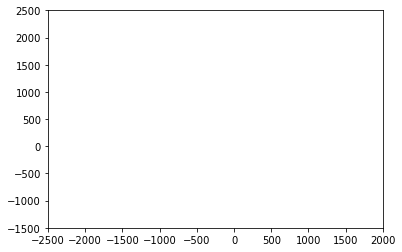

In [9]:
# create a color_list of NP different colors
cmap = cm.get_cmap('Spectral', NP)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# create figure
ax = plt.figure().add_subplot(111)
fig = ax.figure

ax.set_xlim(-2500,2000)
ax.set_ylim(-1500,2500)

# loop on the NP partitions and plot the corresponding collection of patches with a given color
for ip in range(0,NP):
    ax.add_collection(preparecollection4plt(allpatchlists[ip],color_list[ip]))



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation
from matplotlib import cm, patches, collections

from pynextsim import NextsimBin
from pynextsim.nextsim_mesh import NextsimMesh

from pynextsim.gmshlib import GmshMesh

from pynextsim.drifter_time_series import *
import pynextsim.lib as nsl

%matplotlib notebook

In [5]:
experiment='run2_330d_partnodisk'
mesh_file='/data/experiments/'+experiment+'/mesh_final.bin'
mesh = NextsimMesh(mesh_file)

ValueError: Cannot open /data/experiments/run2_330d_partnodisk/mesh_final.bin or /data/experiments/run2_330d_partnodisk/mesh_final.bin.bin

In [3]:
experiment2='run2_330d_partnodisk'
mesh_file2='/bettik/alberta/small-arctic-10km-sidfex/experiments/'+experiment2+'/mesh_final.bin'
mesh2 = NextsimMesh(mesh_file2)

In [4]:
mesh2.mapping

AttributeError: Unknown attribute mapping

In [34]:
field_file='/bettik/alberta/small-arctic-10km-iabp/experiments/'+experiment+'/field_final.bin'
field = NextsimBin(field_file)

In [35]:
drifters_file='/bettik/alberta/small-arctic-10km-iabp/experiments/'+experiment+'/IABP_Drifters_20060202.txt'

In [36]:
import pandas as pd

In [42]:
df = pd.read_csv(drifters_file, delimiter=r"\s+")

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36847 entries, 0 to 36846
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           36847 non-null  int64  
 1   Month          36847 non-null  int64  
 2   Day            36847 non-null  int64  
 3   Hour           36847 non-null  int64  
 4   BuoyID         36847 non-null  int64  
 5   Lat            36847 non-null  float64
 6   Lon            36847 non-null  float64
 7   Concentration  36847 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.2 MB


In [44]:
df.head()

,Year,Month,Day,Hour,BuoyID,Lat,Lon,Concentration
0,2006,2,2,0,1907,81.979,-127.722,0.99513
1,2006,2,2,0,2415,77.022,-140.799,0.99703
2,2006,2,2,0,2416,73.552,-140.754,0.99617
3,2006,2,2,0,2417,75.104,-141.579,0.99637
4,2006,2,2,0,2419,75.817,-146.290,0.99603


In [46]:
drifters_position = df[["BuoyID","Lat","Lon"]]

In [47]:
drifters_position

,BuoyID,Lat,Lon
0,1907,81.97900,-127.72200
1,2415,77.02200,-140.79900
2,2416,73.55200,-140.75400
3,2417,75.10400,-141.57900
4,2419,75.81700,-146.29000
...,...,...,...
36842,66301,81.20271,177.01060
36843,66304,82.58747,-164.23575
36844,66305,83.91347,-143.25982
36845,66739,83.97900,178.04142


In [51]:
list_buoys = df['BuoyID'].tolist()
list_red = list(dict.fromkeys(list_buoys))
print(len(list_buoys),len(list_red))

36847 60


In [53]:
print(list_red[0])

1907


In [56]:
pos_buoy1=drifters_position.loc[drifters_position['BuoyID'] == list_red[0]]

In [57]:
pos_buoy1

,BuoyID,Lat,Lon
0,1907,81.97900,-127.72200
22,1907,81.97922,-127.72787
44,1907,81.97913,-127.72976
66,1907,81.97907,-127.73086
88,1907,81.97907,-127.73033
...,...,...,...
23449,1907,82.29626,-116.84971
23490,1907,82.29280,-116.86027
23531,1907,82.29123,-116.86103
23572,1907,82.29063,-116.85687


In [59]:
shp = pos_buoy1['Lon'].shape
X = np.nan*np.ones(shape=shp)
Y = np.nan*np.ones(shape=shp)
X,Y=mesh.mapping(pos_buoy1['Lon'].shape,pos_buoy1['Lat'].shape)

AttributeError: Unknown attribute mapping

In [62]:
experiment2='run2_330d_partnodisk'
mesh_file2='/bettik/alberta/small-arctic-10km-sidfex/experiments/'+experiment2+'/mesh_final.bin'
mesh2 = NextsimMesh(mesh_file2)

In [64]:
mesh2.mapping

AttributeError: Unknown attribute mapping